Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3333 entries, 0 to 3332
Data columns (total 20 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   State                   3333 non-null   object 
 1   Account length          3333 non-null   int64  
 2   Area code               3333 non-null   int64  
 3   International plan      3333 non-null   object 
 4   Voice mail plan         3333 non-null   object 
 5   Number vmail messages   3333 non-null   int64  
 6   Total day minutes       3333 non-null   float64
 7   Total day calls         3333 non-null   int64  
 8   Total day charge        3333 non-null   float64
 9   Total eve minutes       3333 non-null   float64
 10  Total eve calls         3333 non-null   int64  
 11  Total eve charge        3333 non-null   float64
 12  Total night minutes     3333 non-null   float64
 13  Total night calls       3333 non-null   int64  
 14  Total night charge      33

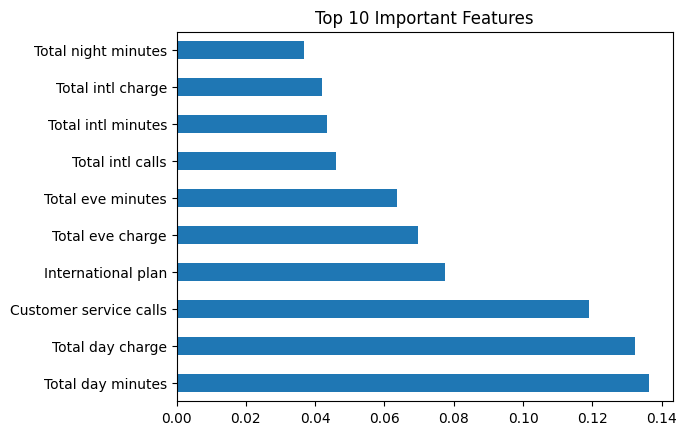

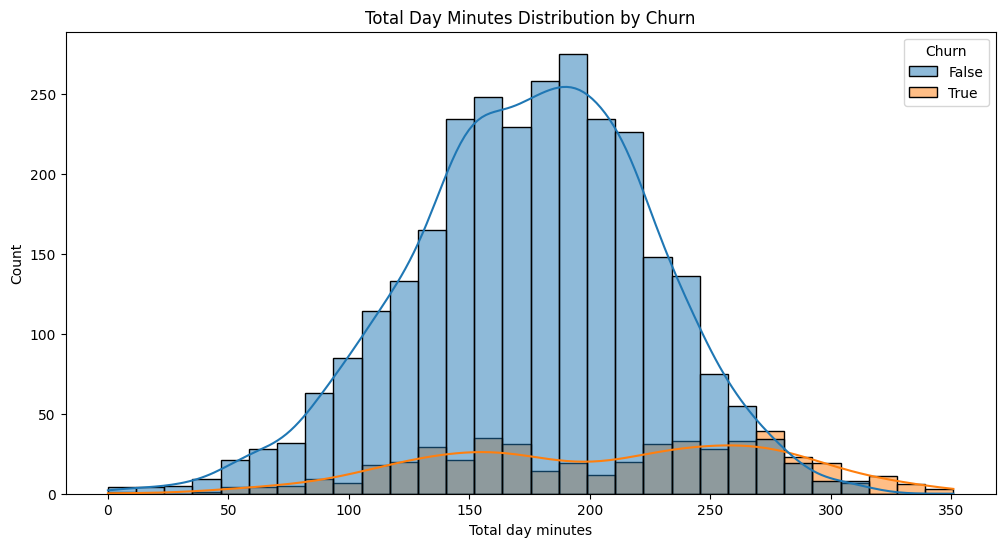

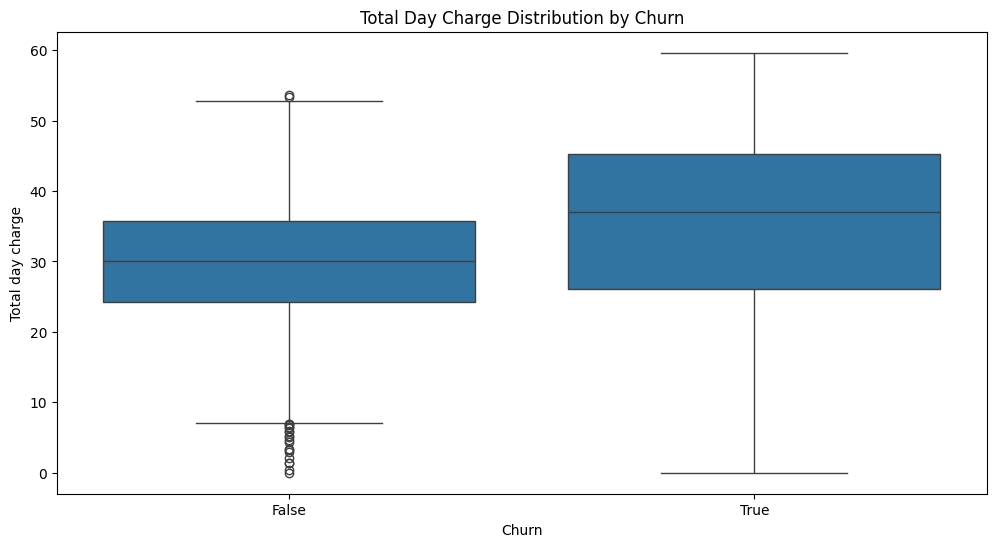

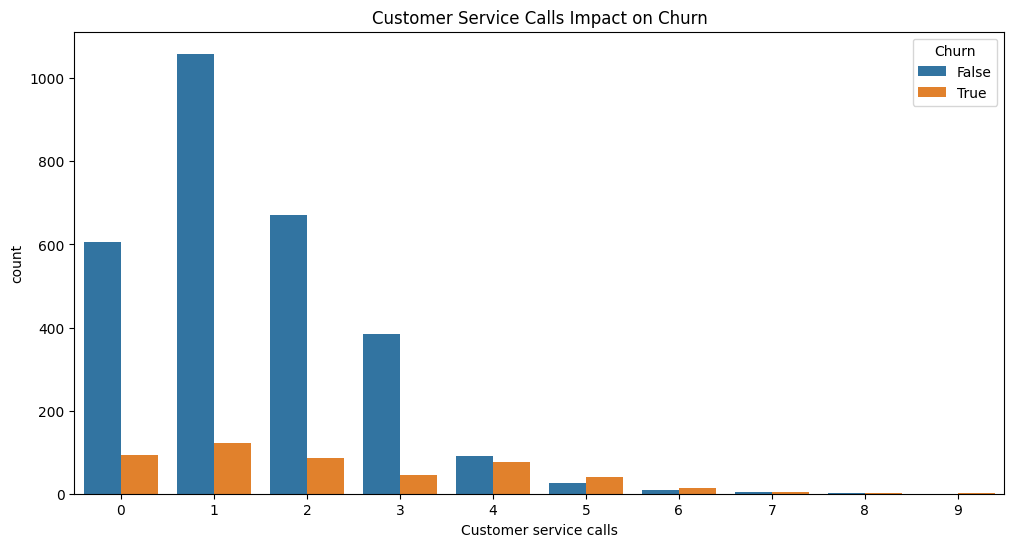

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score, roc_auc_score,
    confusion_matrix, classification_report
)
import joblib
import os

# --------------------------
# 1. Load and Explore Dataset
# --------------------------
df = pd.read_csv('/content/telecom_churn.csv')
df.columns = df.columns.str.strip()  # Remove whitespace in column names

print("Dataset Info:")
print(df.info())
print("\nFirst 5 Rows:")
print(df.head())

# --------------------------
# 2. Data Preprocessing
# --------------------------
# Define target variable
target = 'Churn'

# Encode categorical variables
label_encoders = {}
for col in ['State', 'International plan', 'Voice mail plan']:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col])
    label_encoders[col] = le

# Define target and features
X = df.drop(columns=[target])
y = df[target]

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Further split test set for upload data
X_test, X_upload, y_test, y_upload = train_test_split(X_test, y_test, test_size=0.5, random_state=42)

# Scale numerical features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)
X_upload = scaler.transform(X_upload)

# Save datasets
train_data = pd.DataFrame(X_train, columns=X.columns)
train_data[target] = y_train.reset_index(drop=True)
train_data.to_csv("/content/train_data.csv", index=False)

test_data = pd.DataFrame(X_test, columns=X.columns)
test_data[target] = y_test.reset_index(drop=True)
test_data.to_csv("/content/test_data.csv", index=False)

upload_data = pd.DataFrame(X_upload, columns=X.columns)
upload_data[target] = y_upload.reset_index(drop=True)
upload_data.to_csv("/content/upload_data.csv", index=False)

print("Datasets saved successfully!")

# --------------------------
# 3. Model Training
# --------------------------
# Train Logistic Regression
log_model = LogisticRegression()
log_model.fit(X_train, y_train)
y_pred_log = log_model.predict(X_test)

# Train Random Forest
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)
y_pred_rf = rf_model.predict(X_test)

# --------------------------
# 4. Model Evaluation
# --------------------------
def evaluate_model(name, y_test, y_pred):
    print(f"\n{name} Model Evaluation:")
    print("Accuracy:", accuracy_score(y_test, y_pred))
    print("Precision:", precision_score(y_test, y_pred))
    print("Recall:", recall_score(y_test, y_pred))
    print("F1 Score:", f1_score(y_test, y_pred))
    print("ROC AUC:", roc_auc_score(y_test, y_pred))
    print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
    print("Classification Report:\n", classification_report(y_test, y_pred))

evaluate_model("Logistic Regression", y_test, y_pred_log)
evaluate_model("Random Forest", y_test, y_pred_rf)

# --------------------------
# 5. Save the Best Model
# --------------------------
best_model = rf_model if f1_score(y_test, y_pred_rf) > f1_score(y_test, y_pred_log) else log_model
joblib.dump(best_model, 'best_model.pkl')
print("Best model saved as best_model.pkl")
# Assuming you've already created and fitted a scaler (e.g., StandardScaler)
scaler = StandardScaler()
scaler.fit(X_train)  # X_train is the training data that you scaled earlier

# Create the 'models' directory if it doesn't exist
os.makedirs('models', exist_ok=True)
# Save the scaler
joblib.dump(scaler, 'models/scaler.pkl')

# --------------------------
# 6. Feature Importance Visualization
# --------------------------
if isinstance(best_model, RandomForestClassifier):
    feat_importances = pd.Series(best_model.feature_importances_, index=X.columns)
    feat_importances.nlargest(10).plot(kind='barh')
    plt.title("Top 10 Important Features")
    plt.show()

# --------------------------
# 7. Data Visualizations
# --------------------------
plt.figure(figsize=(12, 6))
sns.histplot(df, x='Total day minutes', bins=30, kde=True, hue=target)
plt.title('Total Day Minutes Distribution by Churn')
plt.show()

plt.figure(figsize=(12, 6))
sns.boxplot(x=df[target], y=df['Total day charge'])
plt.title('Total Day Charge Distribution by Churn')
plt.show()

plt.figure(figsize=(12, 6))
sns.countplot(x=df['Customer service calls'], hue=df[target])
plt.title('Customer Service Calls Impact on Churn')
plt.show()
